# Exploratory Data Analysis & Modeling

In [2]:
from radiant_mlhub import Dataset, Collection, client, get_session
import tarfile
from pathlib import Path
import os
import shutil
from io import BytesIO
from glob import glob
from tqdm.notebook import tqdm
import tifffile as tiff
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import PIL as pil
import json
import seaborn as sns

## Load Data

In [3]:
# Main dataset
dataset_df = pd.read_json("dataset_df.json")

# View first five rows
dataset_df.head()

,source_file,label
0,C:\Users\jenna\Documents\MCP\Spring_2022\MUSA6...,banana
1,C:\Users\jenna\Documents\MCP\Spring_2022\MUSA6...,maize
2,C:\Users\jenna\Documents\MCP\Spring_2022\MUSA6...,legumes
3,C:\Users\jenna\Documents\MCP\Spring_2022\MUSA6...,legumes
4,C:\Users\jenna\Documents\MCP\Spring_2022\MUSA6...,structure


In [4]:
# Dataframe containing the keys
key_df = pd.read_json("key_df.json")

# View first five rows
key_df.head()

,index,source_file,label
0,4,C:\Users\jenna\Documents\MCP\Spring_2022\MUSA6...,structure
1,5,C:\Users\jenna\Documents\MCP\Spring_2022\MUSA6...,structure
2,8,C:\Users\jenna\Documents\MCP\Spring_2022\MUSA6...,structure
3,9,C:\Users\jenna\Documents\MCP\Spring_2022\MUSA6...,structure
4,10,C:\Users\jenna\Documents\MCP\Spring_2022\MUSA6...,structure


In [5]:
# Output path where the data is located and version of the path as a string
output_path = Path("./data/").resolve()
output_path_str = str(Path(output_path))

In [6]:
# Access to the data on local system
data_root=f"{output_path}/Images" 

In [7]:
# Print classes from the Images folder
selectedClasses = (os.listdir(data_root))
print (selectedClasses)

['banana', 'forest', 'legumes', 'maize', 'other', 'structure']


In [8]:
# How many images are in the dataset
print("Total images in the dataset: ", len(dataset_df))

Total images in the dataset:  2606


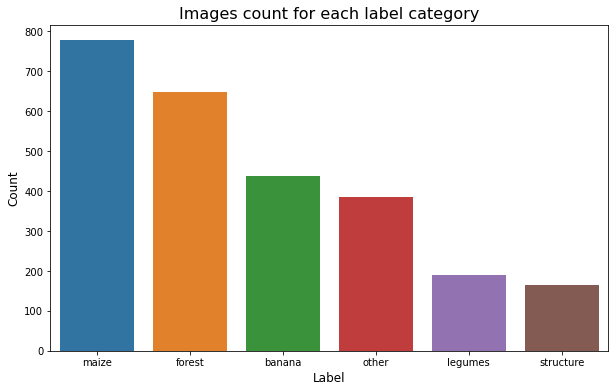

In [9]:
# Check image counts per category, just for reference
ac_count = dataset_df['label'].value_counts()
plt.figure(figsize=(10,6))
sns.barplot(x=ac_count.index, y=ac_count.values)
plt.title("Images count for each label category", fontsize=16)
plt.xlabel("Label", fontsize=12)
plt.ylabel("Count", fontsize=12)
plt.show();

In [10]:
import keras
from keras.preprocessing.image import ImageDataGenerator
import tensorflow as tf #deep learning


### Plot some sample images before any data augmentation

In [11]:
DATA_DIR = str(data_root) # data directory

In [12]:
datagen_plot = ImageDataGenerator()
generator_plot = datagen_plot.flow_from_directory(
    DATA_DIR,
    target_size=(224, 224), #image size (resized for better visualisation clarity)
    shuffle = True, #randomize
    subset='training')

Found 2606 images belonging to 6 classes.


In [13]:
#function for plotting images with labels
def plots(ims, figsize = (10,10), rows=4, interp=False, titles=None, maxNum = 10):
    if type(ims[0] is np.ndarray):
        ims = np.array(ims).astype(np.uint8)
        if(ims.shape[-1] != 3):
            ims = ims.transpose((0,2,3,1))
           
    f = plt.figure(figsize=figsize)
    cols = maxNum // rows if maxNum % 2 == 0 else maxNum//rows + 1
    for i in range(maxNum):
        sp = f.add_subplot(rows, cols, i+1)
        sp.axis('Off')
        if titles is not None:
            sp.set_title(titles[i], fontsize=12)
        plt.imshow(ims[i], interpolation = None if interp else 'none')  

In [14]:
generator_plot.reset()
imgs, labels = generator_plot.next() # images to plot

# including labels
labelNames=[]
labelIndices=[np.where(r==1)[0][0] for r in labels]

for ind in labelIndices:
    for labelName,labelIndex in generator_plot.class_indices.items():
        if labelIndex == ind:
            labelNames.append(labelName)

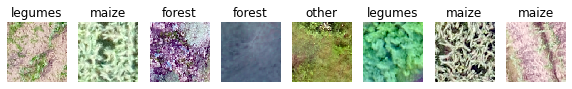

In [15]:
plots(imgs, rows=1, titles = labelNames, maxNum=8)


### Creating data matrices

In [16]:
#reading images from local images folder -- replace and comment out the duplicate
dataPath = "C:/Users/kchan/Desktop/Spring2022/RemoteSensing/Final/FinalRepo/MUSA650_Final_ChangEpstein/data/Images"
#dataPath = "C:/Users/jenna/Documents/MCP/Spring_2022/MUSA650_RemoteSensing/Final/MUSA650_Final_ChangEpstein/data/Images"

#array of unique labels
labelList = os.listdir(dataPath)

#read images
numClass = len(labelList)

lenClass = np.zeros(numClass)
for i in np.arange(0, numClass):
    lenClass[i] = len(os.listdir(dataPath + '/' + labelList[i]))
#returns the number of images in each class
lenClass 

array([438., 649., 190., 778., 385., 166.])

In [17]:
#returns the total number of images
numImg = int(lenClass.sum())
numImg

2606

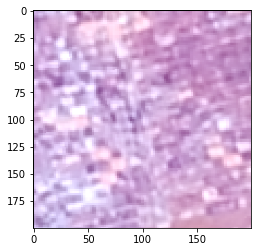

In [18]:
#plotting one image
import PIL

imgSel = dataPath + '/' + labelList[i] + '/' + os.listdir(dataPath + '/' + labelList[i])[29] #this can be any number between 0-165 idk why
img = PIL.Image.open(imgSel, 'r')
plt.imshow(np.asarray(img))

In [19]:
np.asarray(img).shape
#200x200 and 3 color channels - does it need to be 224x224?

(200, 200, 3)

In [20]:
#returns total number of pixels per each image
numPixels = np.prod(np.asarray(img).shape)
numPixels

120000

In [21]:
# Extract color channels from each image and flatten to a feature matrix X
X = np.zeros([numImg, numPixels])

# Create the numeric labels y for each image
y = np.zeros(numImg)

In [22]:
# creating a dictionary to make it easier to match up text labels with numeric
class_dict = dict(zip(labelList, range(len(labelList))))
class_dict  

{'banana': 0,
 'forest': 1,
 'legumes': 2,
 'maize': 3,
 'other': 4,
 'structure': 5}

In [23]:
imgInd = 0
for i in np.arange(0, numClass):
  className = labelList[i]
  for imgName in os.listdir(dataPath + '/' + className):
    img = PIL.Image.open(dataPath + '/' + className + '/' + imgName, 'r')
    imgVec = np.asarray(img).flatten()
    X[imgInd,:] = imgVec
    y[imgInd] = i
    imgInd = imgInd + 1
    print('Read img class ' + className + ' no ' + str(imgInd))

Read img class banana no 1
Read img class banana no 2
Read img class banana no 3
Read img class banana no 4
Read img class banana no 5
Read img class banana no 6
Read img class banana no 7
Read img class banana no 8
Read img class banana no 9
Read img class banana no 10
Read img class banana no 11
Read img class banana no 12
Read img class banana no 13
Read img class banana no 14
Read img class banana no 15
Read img class banana no 16
Read img class banana no 17
Read img class banana no 18
Read img class banana no 19
Read img class banana no 20
Read img class banana no 21
Read img class banana no 22
Read img class banana no 23
Read img class banana no 24
Read img class banana no 25
Read img class banana no 26
Read img class banana no 27
Read img class banana no 28
Read img class banana no 29
Read img class banana no 30
Read img class banana no 31
Read img class banana no 32
Read img class banana no 33
Read img class banana no 34
Read img class banana no 35
Read img class banana no 36
R

In [24]:
#shape of X before splitting
X.shape

(2606, 120000)

In [25]:
#shape of y before splitting
y.shape

(2606,)

### KNN Model

In [26]:
#splitting the data, using stratify to ensure even distribution of each classes in each set
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.2, random_state=42, stratify=y)


In [27]:
X_train.shape

(2084, 120000)

In [28]:
X_test.shape

(522, 120000)

In [29]:
# Defining knn classifier
from sklearn.neighbors import KNeighborsClassifier
knn_clf = KNeighborsClassifier(n_neighbors=5) # Start with 5 neighbors just to get baseline accuracy

In [30]:
# Scale and transform
from sklearn.preprocessing import StandardScaler

sc = StandardScaler()

X_train = sc.fit_transform(X_train)
X_test = sc.fit_transform(X_test)

In [31]:
# Train the model
knn_clf.fit(X_train, y_train)

KNeighborsClassifier()

In [32]:
# Apply the model
knn_preds = knn_clf.predict(X_test)

In [33]:
# Evaluate model
from sklearn.metrics import accuracy_score, plot_confusion_matrix
accuracy_score(y_test, knn_preds)

0.3946360153256705

In [34]:
# Optimize parameters -- NOTE: this takes 10 min ito run
# Source: https://machinelearningknowledge.ai/knn-classifier-in-sklearn-using-gridsearchcv-with-example/
from sklearn.model_selection import GridSearchCV
# Defining range of parameters
k_range = list(range(1,31))
param_grid_knn = dict(n_neighbors = k_range)

#defining grid
grid_knn = GridSearchCV(knn_clf, param_grid_knn, cv=10, scoring='accuracy', return_train_score=False, verbose=1)

#fitting model for grid search
grid_search_knn = grid_knn.fit(X_train, y_train)

Fitting 10 folds for each of 30 candidates, totalling 300 fits


KeyboardInterrupt: 

In [35]:
#print best parameters
print(grid_search_knn.best_params_)

#10 folds for 30 candidates range(1,31) defines 27 neighbors as optimal

NameError: name 'grid_search_knn' is not defined

In [36]:
# Now that we have best params, run again

# Defining knn classifier
knn_clf_best = KNeighborsClassifier(n_neighbors=27) #using 27 from gridSearchCV

In [37]:
# Train the model
knn_clf_best.fit(X_train, y_train)

KNeighborsClassifier(n_neighbors=27)

In [38]:
# Apply the model
knn_preds_best = knn_clf_best.predict(X_test)

In [39]:
# Evaluate model
accuracy_score(y_test, knn_preds_best)

0.41954022988505746

In [40]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.metrics import roc_auc_score

print("KNN accuracy score: ",accuracy_score(y_test,knn_preds_best))
print("KNN classification report \n",classification_report(y_test,knn_preds_best))

knn_cm = confusion_matrix(y_test,knn_preds_best,  labels = knn_clf_best.classes_)

KNN accuracy score:  0.41954022988505746
KNN classification report 
               precision    recall  f1-score   support

         0.0       0.91      0.11      0.20        88
         1.0       0.39      0.89      0.55       130
         2.0       0.18      0.05      0.08        38
         3.0       0.65      0.18      0.28       156
         4.0       0.26      0.42      0.32        77
         5.0       0.76      0.94      0.84        33

    accuracy                           0.42       522
   macro avg       0.53      0.43      0.38       522
weighted avg       0.55      0.42      0.36       522



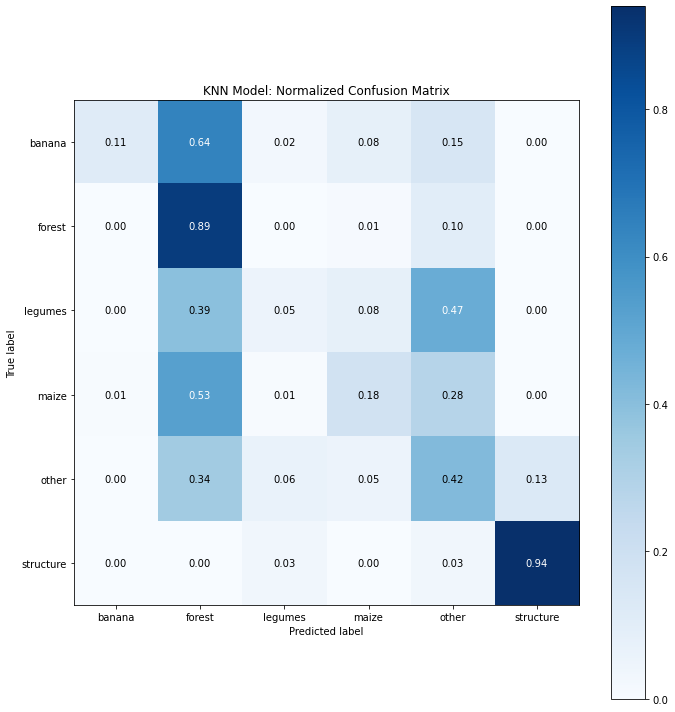

In [41]:
# Plot the confusion matrix
%matplotlib inline
cm = knn_cm.astype('float') / knn_cm.sum(axis=1)[:, np.newaxis]
fig, ax = plt.subplots(figsize=(10, 10))
im = ax.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
ax.figure.colorbar(im, ax=ax)

# Show all ticks
ax.set(xticks=np.arange(cm.shape[1]),
       yticks=np.arange(cm.shape[0]),
       # and label them with the respective list entries
       xticklabels=labelList, yticklabels=labelList,
       title='KNN Model: Normalized Confusion Matrix',
       ylabel='True label',
       xlabel='Predicted label')

# Loop over data dimensions and create text annotations
fmt = '.2f'
thresh = cm.max() / 2.
for i in range(cm.shape[0]):
    for j in range(cm.shape[1]):
        ax.text(j, i, format(cm[i, j], fmt),
                ha="center", va="center",
                color="white" if cm[i, j] > thresh else "black")
fig.tight_layout()

### Random Forest

In [42]:
# Defining rf classifier
from sklearn.ensemble import RandomForestClassifier
rf_clf = RandomForestClassifier(max_depth=10, n_estimators=100, max_features=1)

In [43]:
# Train the model
rf_clf.fit(X_train, y_train)

RandomForestClassifier(max_depth=10, max_features=1)

In [44]:
# Apply the model
rf_preds = rf_clf.predict(X_test)

In [45]:
# Evaluate model
accuracy_score(y_test, rf_preds)

0.6015325670498084

In [ ]:
# Optimize parameters - should only take <5 min to run currently
# Source: https://stackoverflow.com/questions/30102973/how-to-get-best-estimator-on-gridsearchcv-random-forest-classifier-scikit
# Defining range of parameters
param_grid_rf = {
    'max_depth': [5, 10, 15],
    'n_estimators': [200, 700, 900]
}

#defining grid
grid_rf = GridSearchCV(rf_clf, param_grid_rf, cv=10, scoring='accuracy', return_train_score=False, verbose=1)

#fitting model for grid search
grid_search_rf = grid_rf.fit(X_train, y_train)

In [ ]:
# Print best parameters
print(grid_search_rf.best_params_)

In [46]:
# Defining rf classifier with best params
rf_clf_best = RandomForestClassifier(max_depth=15, n_estimators=700, max_features=1)

In [47]:
# Train the model
rf_clf_best.fit(X_train, y_train)

RandomForestClassifier(max_depth=15, max_features=1, n_estimators=700)

In [48]:
# Apply the model
rf_preds_best = rf_clf_best.predict(X_test)

In [49]:
# Evaluate model
accuracy_score(y_test, rf_preds_best)

0.6245210727969349

In [50]:
print("RF accuracy score: ",accuracy_score(y_test,rf_preds_best))
print("RF classification report \n",classification_report(y_test,rf_preds_best))

rf_cm = confusion_matrix(y_test,rf_preds_best, labels = rf_clf_best.classes_)

RF accuracy score:  0.6245210727969349
RF classification report 
               precision    recall  f1-score   support

         0.0       0.66      0.55      0.60        88
         1.0       0.62      0.69      0.65       130
         2.0       0.00      0.00      0.00        38
         3.0       0.57      0.84      0.68       156
         4.0       0.66      0.32      0.43        77
         5.0       0.86      0.97      0.91        33

    accuracy                           0.62       522
   macro avg       0.56      0.56      0.55       522
weighted avg       0.59      0.62      0.59       522



C:\Users\kchan\anaconda3\envs\musa-650\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\kchan\anaconda3\envs\musa-650\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\kchan\anaconda3\envs\musa-650\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


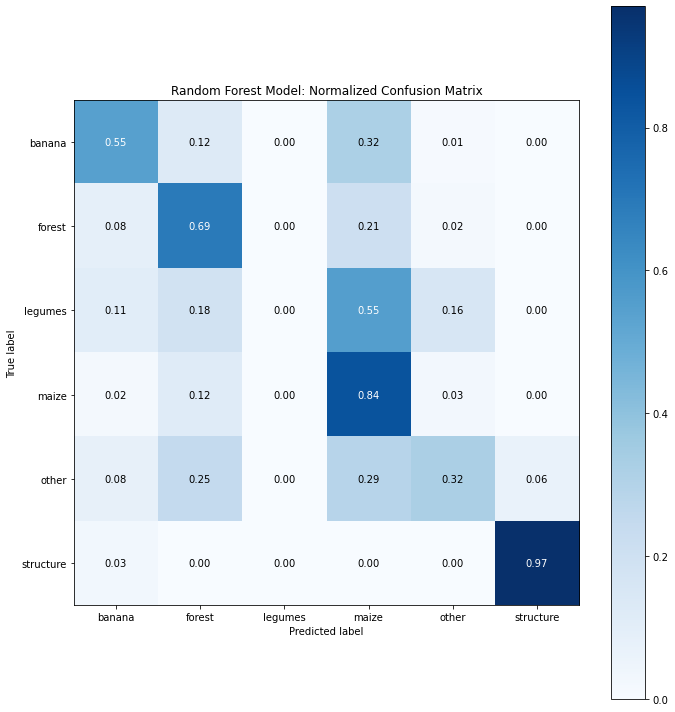

In [51]:
# Plot the confusion matrix
%matplotlib inline
cm = rf_cm.astype('float') / rf_cm.sum(axis=1)[:, np.newaxis]
fig, ax = plt.subplots(figsize=(10, 10))
im = ax.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
ax.figure.colorbar(im, ax=ax)

# Show all ticks
ax.set(xticks=np.arange(cm.shape[1]),
       yticks=np.arange(cm.shape[0]),
       # and label them with the respective list entries
       xticklabels=labelList, yticklabels=labelList,
       title='Random Forest Model: Normalized Confusion Matrix',
       ylabel='True label',
       xlabel='Predicted label')

# Loop over data dimensions and create text annotations
fmt = '.2f'
thresh = cm.max() / 2.
for i in range(cm.shape[0]):
    for j in range(cm.shape[1]):
        ax.text(j, i, format(cm[i, j], fmt),
                ha="center", va="center",
                color="white" if cm[i, j] > thresh else "black")
fig.tight_layout()

## CNN 1st attempt

In [52]:
#reading in images and retaining rgb
import glob
import os

img_files = []

for file in glob.glob(dataPath + os.sep + "*" + os.sep + "*.png"):
    img_files.append(file)

In [54]:
#load rgb images
from skimage import io

imgs_rgb = []

for imgName in img_files:
    temp = io.imread(imgName)
    imgs_rgb.append(temp)

In [55]:
#convert to array
RGBimages = np.stack(imgs_rgb)

In [56]:
#check shape
RGBimages.shape

(2606, 200, 200, 3)

In [57]:
#split data
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(RGBimages,y,test_size=0.5, random_state=42, stratify=y)

In [58]:
#scale and transform
from sklearn.preprocessing import MinMaxScaler
scalar = MinMaxScaler()
scalar.fit(X_train.reshape(X_train.shape[0], -1))
X_train = scalar.transform(X_train.reshape(X_train.shape[0], -1)).reshape(X_train.shape)
X_test = scalar.transform(X_test.reshape(X_test.shape[0], -1)).reshape(X_test.shape)

In [59]:
#set global params
batch_size = 64
epochs = 12
input_shape =(200,200,3)

In [60]:
import tensorflow as tf 
import keras
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation, Flatten
from keras.layers import Conv2D, MaxPooling2D
from keras import backend as K
from tensorflow.keras.layers import BatchNormalization

In [74]:
cnn1 = Sequential()

cnn1.add(Conv2D(64, kernel_size=(3, 3),strides=(1,1),input_shape=input_shape))
cnn1.add(BatchNormalization())
cnn1.add(Activation('relu'))
cnn1.add(MaxPooling2D((2,2)))

cnn1.add(Dropout(0.5))

cnn1.add(Flatten())
cnn1.add(Dense(numClass, activation='softmax'))

cnn1.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_3 (Conv2D)           (None, 198, 198, 64)      1792      
                                                                 
 batch_normalization_3 (Batc  (None, 198, 198, 64)     256       
 hNormalization)                                                 
                                                                 
 activation_3 (Activation)   (None, 198, 198, 64)      0         
                                                                 
 max_pooling2d_3 (MaxPooling  (None, 99, 99, 64)       0         
 2D)                                                             
                                                                 
 dropout_3 (Dropout)         (None, 99, 99, 64)        0         
                                                                 
 flatten_3 (Flatten)         (None, 627264)           

In [75]:
cnn1.compile(loss=keras.losses.sparse_categorical_crossentropy,
              optimizer=tf.keras.optimizers.Adam(),
              metrics=['accuracy'])

In [76]:
cnn1.fit(X_train, y_train,
          batch_size=batch_size,
          epochs=epochs,
          verbose=1,
          validation_data=(X_test, y_test))

Epoch 1/12
21/21 [==============================] - 62s 3s/step - loss: 74.3610 - accuracy: 0.3315 - val_loss: 28.6560 - val_accuracy: 0.0683
Epoch 2/12
21/21 [==============================] - 60s 3s/step - loss: 18.7415 - accuracy: 0.5503 - val_loss: 5.7754 - val_accuracy: 0.2525
Epoch 3/12
21/21 [==============================] - 60s 3s/step - loss: 8.9766 - accuracy: 0.6585 - val_loss: 3.4791 - val_accuracy: 0.2579
Epoch 4/12
21/21 [==============================] - 61s 3s/step - loss: 5.8092 - accuracy: 0.6946 - val_loss: 3.8218 - val_accuracy: 0.3239
Epoch 5/12
21/21 [==============================] - 61s 3s/step - loss: 4.6169 - accuracy: 0.7437 - val_loss: 4.4167 - val_accuracy: 0.3331
Epoch 6/12
21/21 [==============================] - 61s 3s/step - loss: 2.9314 - accuracy: 0.8120 - val_loss: 1.6247 - val_accuracy: 0.4827
Epoch 7/12
21/21 [==============================] - 60s 3s/step - loss: 3.1919 - accuracy: 0.7905 - val_loss: 2.1392 - val_accuracy: 0.3684
Epoch 8/12
21/21 

In [77]:
score = cnn1.evaluate(X_test, y_test, verbose=0)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

Test loss: 1.9067703485488892
Test accuracy: 0.5763622522354126


## CNN Attempt 2

In [78]:
#split original data for rescaling layer
X_train, X_test, y_train, y_test = train_test_split(RGBimages,y,test_size=0.5, random_state=42, stratify=y)

In [79]:
# Adding a rescaling layer to help with scaling the data. This is done in place of minmaxscalar to achieve similar effect.
from tensorflow.keras import layers
rescaling_layer = layers.experimental.preprocessing.Rescaling(
    scale=1. / 255,
    input_shape=input_shape)

In [88]:
cnn2 = Sequential()
cnn2.add(rescaling_layer)

cnn2.add(Conv2D(64, kernel_size=(3, 3),strides=(1,1),input_shape=input_shape))
cnn2.add(BatchNormalization())
cnn2.add(Activation('relu'))
cnn2.add(MaxPooling2D((2,2)))

cnn2.add(Dropout(0.5))

cnn2.add(Flatten())
cnn2.add(Dense(numClass, activation='softmax'))

cnn2.summary()

Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling (Rescaling)       (None, 200, 200, 3)       0         
                                                                 
 conv2d_8 (Conv2D)           (None, 198, 198, 64)      1792      
                                                                 
 batch_normalization_4 (Batc  (None, 198, 198, 64)     256       
 hNormalization)                                                 
                                                                 
 activation_4 (Activation)   (None, 198, 198, 64)      0         
                                                                 
 max_pooling2d_6 (MaxPooling  (None, 99, 99, 64)       0         
 2D)                                                             
                                                                 
 dropout_8 (Dropout)         (None, 99, 99, 64)       

In [89]:
cnn2.compile(loss=keras.losses.sparse_categorical_crossentropy,
              optimizer=tf.keras.optimizers.Adam(),
              metrics=['accuracy'])

In [90]:
cnn2.fit(X_train, y_train,
                    batch_size=batch_size,
                    epochs=epochs,
                    verbose=1,
                    validation_data=(X_test, y_test))

Epoch 1/12
21/21 [==============================] - 53s 3s/step - loss: 63.3004 - accuracy: 0.3722 - val_loss: 5.9206 - val_accuracy: 0.2970
Epoch 2/12
21/21 [==============================] - 54s 3s/step - loss: 16.3531 - accuracy: 0.5748 - val_loss: 7.7788 - val_accuracy: 0.2126
Epoch 3/12
21/21 [==============================] - 52s 3s/step - loss: 6.5856 - accuracy: 0.6792 - val_loss: 2.7257 - val_accuracy: 0.3761
Epoch 4/12
21/21 [==============================] - 53s 3s/step - loss: 7.5117 - accuracy: 0.6592 - val_loss: 4.5139 - val_accuracy: 0.1781
Epoch 5/12
21/21 [==============================] - 56s 3s/step - loss: 3.6720 - accuracy: 0.7813 - val_loss: 2.7170 - val_accuracy: 0.2724
Epoch 6/12
21/21 [==============================] - 51s 2s/step - loss: 1.7151 - accuracy: 0.8557 - val_loss: 2.2375 - val_accuracy: 0.3369
Epoch 7/12
21/21 [==============================] - 51s 2s/step - loss: 1.4910 - accuracy: 0.8634 - val_loss: 1.8257 - val_accuracy: 0.4421
Epoch 8/12
21/21 [

In [91]:
score = cnn2.evaluate(X_test, y_test, verbose=0)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

Test loss: 2.5399038791656494
Test accuracy: 0.4811972379684448


## VGG-16 

In [99]:
#split data
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(RGBimages,y,test_size=0.5, random_state=42, stratify=y)

In [100]:
#scale and transform
from sklearn.preprocessing import MinMaxScaler
scalar = MinMaxScaler()
scalar.fit(X_train.reshape(X_train.shape[0], -1))
X_train = scalar.transform(X_train.reshape(X_train.shape[0], -1)).reshape(X_train.shape)
X_test = scalar.transform(X_test.reshape(X_test.shape[0], -1)).reshape(X_test.shape)

In [106]:
from tensorflow.keras.applications.vgg16 import VGG16

vgg16_base_1 = VGG16(input_shape = input_shape, # Shape of our images
                    include_top = False, # Leave out the last fully connected layer
                    weights = 'imagenet')
vgg16_base_1.trainable = False

# Flatten the output layer to 1 dimension
x = layers.Flatten()(vgg16_base_1.output)

# Add a fully connected layer with 512 hidden units and ReLU activation
x = layers.Dense(256, activation='relu')(x) # 1024 ,512

# Add a dropout rate of 0.5
x = layers.Dropout(0.5)(x)

# Add a final sigmoid layer with 1 node for classification output
x = layers.Dense(numClass, activation='softmax')(x)

vgg16_model_1 = tf.keras.models.Model(vgg16_base_1.input, x)

#model1.compile(optimizer = tf.keras.optimizers.RMSprop(lr=0.0001), loss = 'binary_crossentropy',metrics = ['acc'])
vgg16_model_1.compile(optimizer = 'adam',loss = 'sparse_categorical_crossentropy',metrics=['accuracy'])

vgg16_model_1.summary()

Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 200, 200, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 200, 200, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 200, 200, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 100, 100, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 100, 100, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 100, 100, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 50, 50, 128)       0   

In [108]:
# Fit the model
from tensorflow.keras.callbacks import EarlyStopping

es = EarlyStopping(monitor='val_accuracy', mode='max', patience=5,  restore_best_weights=True)

vgg16_model_1.fit(X_train, y_train, epochs=12, validation_split=0.2, batch_size=64, callbacks=[es])


Epoch 1/12
17/17 [==============================] - 104s 6s/step - loss: 1.7930 - accuracy: 0.4875 - val_loss: 1.2590 - val_accuracy: 0.5326
Epoch 2/12
17/17 [==============================] - 110s 7s/step - loss: 1.0501 - accuracy: 0.6065 - val_loss: 1.0131 - val_accuracy: 0.6322
Epoch 3/12
17/17 [==============================] - 108s 6s/step - loss: 0.9046 - accuracy: 0.6718 - val_loss: 0.9109 - val_accuracy: 0.6360
Epoch 4/12
17/17 [==============================] - 109s 6s/step - loss: 0.8278 - accuracy: 0.6891 - val_loss: 0.9054 - val_accuracy: 0.6437
Epoch 5/12
17/17 [==============================] - 110s 6s/step - loss: 0.7707 - accuracy: 0.7121 - val_loss: 0.9279 - val_accuracy: 0.6513
Epoch 6/12
17/17 [==============================] - 121s 7s/step - loss: 0.7051 - accuracy: 0.7428 - val_loss: 0.9593 - val_accuracy: 0.6322
Epoch 7/12
17/17 [==============================] - 118s 7s/step - loss: 0.7282 - accuracy: 0.7322 - val_loss: 0.8180 - val_accuracy: 0.6897
Epoch 8/12
17

In [109]:
score = vgg16_model_1.evaluate(X_test, y_test, verbose=0)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

Test loss: 0.6901094913482666
Test accuracy: 0.7743668556213379
